In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('AEP_hourly.csv')
df['Datetime']=pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
df


,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


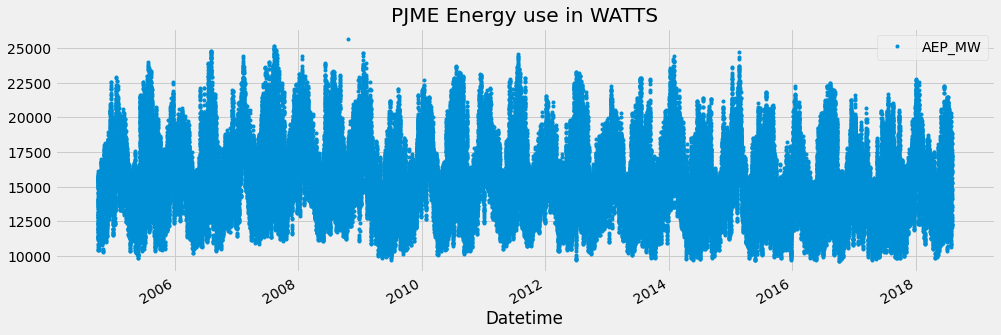

In [ ]:
df.plot(style='.', figsize=(15,5), title='PJME Energy use in WATTS')

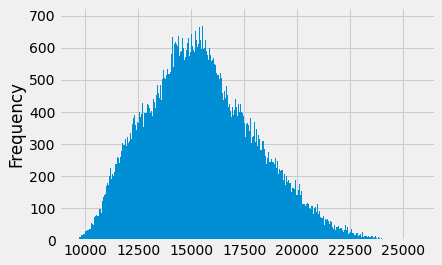

In [ ]:
df['AEP_MW'].plot(kind='hist', bins = 500)

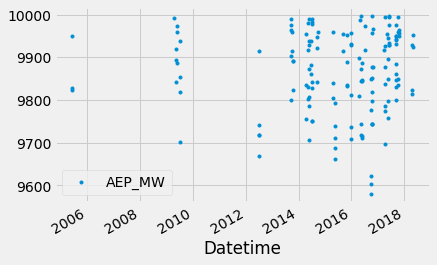

In [ ]:
df.query('AEP_MW < 10000').plot(style='.')

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df=df.sort_index()

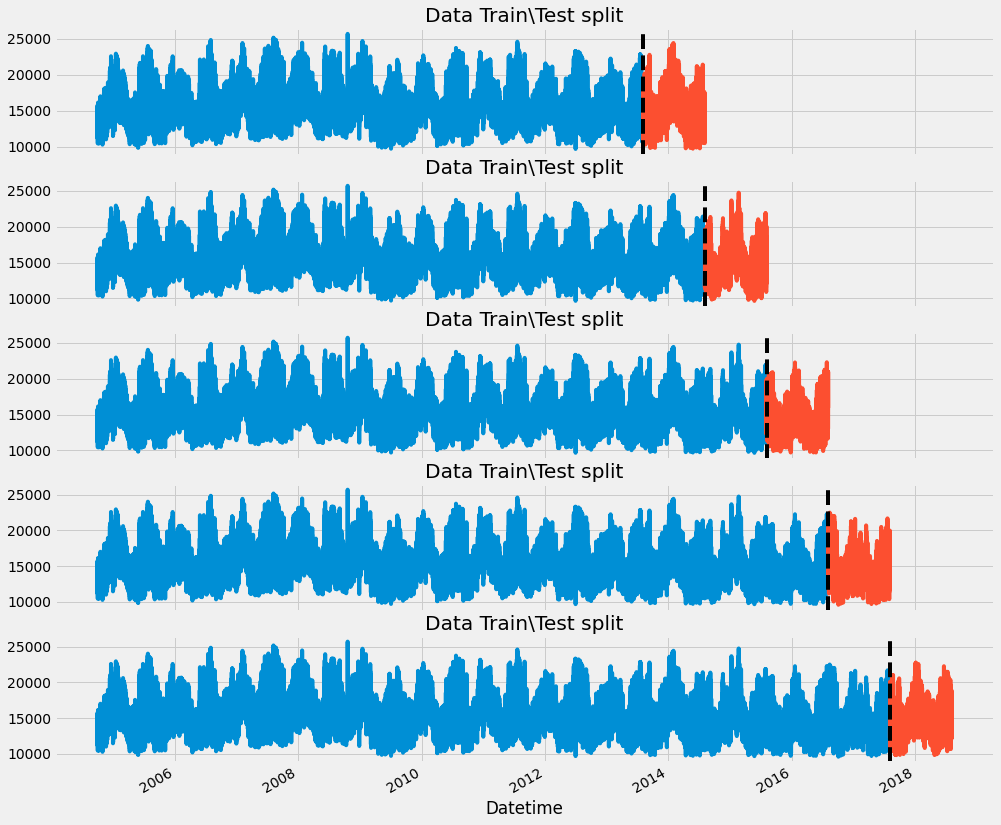

In [ ]:
fig, ax= plt.subplots(5, 1, figsize=(15,15),sharex=True)
fold = 0
for train_idx,val_idx in tss.split(df):
  train = df.iloc[train_idx]
  test = df.iloc[val_idx] 
  train['AEP_MW'].plot(ax=ax[fold],label= 'Training set', title= 'Data Train\Test split')
  test['AEP_MW'].plot(ax=ax[fold],label = 'test set')
  ax[fold].axvline(test.index.min(), color='black', ls='--')
  fold+=1



In [ ]:
def create_features(df):
  df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.day_of_week
  df['month'] = df.index.month
  df['dayofyear'] = df.index.day_of_year
  df['year'] = df.index.year
  df['quarter'] = df.index.quarter
  df['weekofyear'] = df.index.isocalendar().week
  df['dayofmonth'] = df.index.day

  return df

df = create_features(df)

In [ ]:
df.head()

,AEP_MW,hour,dayofweek,month,dayofyear,year,quarter,weekofyear,dayofmonth
Datetime,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,10,275,2004,4,40,1
2004-10-01 02:00:00,11935.0,2,4,10,275,2004,4,40,1
2004-10-01 03:00:00,11692.0,3,4,10,275,2004,4,40,1
2004-10-01 04:00:00,11597.0,4,4,10,275,2004,4,40,1
2004-10-01 05:00:00,11681.0,5,4,10,275,2004,4,40,1


In [ ]:
def lag_features(df):
  Target = df['AEP_MW'].to_dict()
  df['lag1'] = (df.index - pd.Timedelta('364 days')).map(Target)
  df['lag2'] = (df.index - pd.Timedelta('728 days')).map(Target)
  df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(Target)
  return df

df = lag_features(df)  
df.head()

,AEP_MW,hour,dayofweek,month,dayofyear,year,quarter,weekofyear,dayofmonth,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,10,275,2004,4,40,1,NaN,NaN,NaN
2004-10-01 02:00:00,11935.0,2,4,10,275,2004,4,40,1,NaN,NaN,NaN
2004-10-01 03:00:00,11692.0,3,4,10,275,2004,4,40,1,NaN,NaN,NaN
2004-10-01 04:00:00,11597.0,4,4,10,275,2004,4,40,1,NaN,NaN,NaN
2004-10-01 05:00:00,11681.0,5,4,10,275,2004,4,40,1,NaN,NaN,NaN


In [ ]:
df.tail()

,AEP_MW,hour,dayofweek,month,dayofyear,year,quarter,weekofyear,dayofmonth,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,17673.0,20,3,8,214,2018,3,31,2,18705.0,20140.0,16078.0
2018-08-02 21:00:00,17303.0,21,3,8,214,2018,3,31,2,18108.0,19616.0,15908.0
2018-08-02 22:00:00,17001.0,22,3,8,214,2018,3,31,2,17544.0,19246.0,15783.0
2018-08-02 23:00:00,15964.0,23,3,8,214,2018,3,31,2,16262.0,17943.0,14808.0
2018-08-03 00:00:00,14809.0,0,4,8,215,2018,3,31,3,15045.0,16491.0,13669.0


In [ ]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'month', 'dayofyear', 'year', 'quarter',
       'weekofyear', 'dayofmonth', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [ ]:
train.columns

Index(['AEP_MW'], dtype='object')

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df= df.sort_index()
fold = 0
preds=[]
scores = []

for train_idx,test_idx in tss.split(df):
  train = df.iloc[train_idx]
  test = df.iloc[test_idx]

  train = create_features(train)
  test = create_features(test)

  FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
  TARGET = ['AEP_MW']

  x_train = train[FEATURES]
  y_train = train[TARGET]

  x_test = test[FEATURES]
  y_test = test[TARGET]

  reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',n_estimators=1000,objective='reg:linear',max_depth=3)
  reg.fit(x_train,y_train, eval_set=[(x_train,y_train),(x_test,y_test)],early_stopping_rounds=50,verbose=100)
  y_pred = reg.predict(x_test)
  preds.append(y_pred)
  score = np.sqrt(mean_squared_error(y_test,y_pred))
  scores.append(score)

[23:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14472.3	validation_1-rmse:13872.7
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1320.53	validation_1-rmse:1577.58
Stopping. Best iteration:
[69]	validation_0-rmse:1370.62	validation_1-rmse:1542.44

[23:55:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14415	validation_1-rmse:13848.6
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1338.97	validation_1-rmse:1431.82
Stopping. Best iteration:
[56]	validation_0-rmse:1414.8	validation_1-rmse:1420.06

[23:56:04] WARNING: /workspace/src/

In [ ]:
print(f'average values {np.mean(scores)}')
print(scores)

average values 1556.084288188609
[1542.43643975734, 1420.059973144099, 1510.3327792263092, 1613.1454566215086, 1694.4467921937887]


#PREDICTING FUTURE

In [ ]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
TARGET = ['AEP_MW']

x_all = df[FEATURES]
y_all = df[TARGET]


reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',n_estimators=500,objective='reg:linear',max_depth=3)
reg.fit(x_all,y_all, eval_set=[(x_all,y_all)],verbose=100)

[23:56:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14163.6
[100]	validation_0-rmse:1379.05
[200]	validation_0-rmse:1294.7
[300]	validation_0-rmse:1246.15
[400]	validation_0-rmse:1211.19
[499]	validation_0-rmse:1183.33


XGBRegressor(n_estimators=500)

In [ ]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [ ]:
future = pd.date_range('2018-08-03','2019-08-01',freq='1h')
df_future = pd.DataFrame(index = future)
df_future['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df,df_future])
df_and_future = create_features(df_and_future)
df_and_future = lag_features(df_and_future)
df_and_future

,AEP_MW,hour,dayofweek,month,dayofyear,year,quarter,weekofyear,dayofmonth,lag1,lag2,lag3,isFuture
2004-10-01 01:00:00,12379.0,1,4,10,275,2004,4,40,1,NaN,NaN,NaN,False
2004-10-01 02:00:00,11935.0,2,4,10,275,2004,4,40,1,NaN,NaN,NaN,False
2004-10-01 03:00:00,11692.0,3,4,10,275,2004,4,40,1,NaN,NaN,NaN,False
2004-10-01 04:00:00,11597.0,4,4,10,275,2004,4,40,1,NaN,NaN,NaN,False
2004-10-01 05:00:00,11681.0,5,4,10,275,2004,4,40,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,7,212,2019,3,31,31,16579.0,18495.0,20026.0,True
2019-07-31 21:00:00,NaN,21,2,7,212,2019,3,31,31,16457.0,17771.0,19529.0,True
2019-07-31 22:00:00,NaN,22,2,7,212,2019,3,31,31,16197.0,17220.0,19029.0,True
2019-07-31 23:00:00,NaN,23,2,7,212,2019,3,31,31,15259.0,16100.0,17790.0,True


In [ ]:
future_with_features = df_and_future.query('isFuture').copy()
future_with_features.head()

,AEP_MW,hour,dayofweek,month,dayofyear,year,quarter,weekofyear,dayofmonth,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,8,215,2018,3,31,3,15045.0,16491.0,13669.0,True
2018-08-03 01:00:00,NaN,1,4,8,215,2018,3,31,3,13940.0,15319.0,12772.0,True
2018-08-03 02:00:00,NaN,2,4,8,215,2018,3,31,3,13230.0,14492.0,12253.0,True
2018-08-03 03:00:00,NaN,3,4,8,215,2018,3,31,3,12624.0,13945.0,11928.0,True
2018-08-03 04:00:00,NaN,4,4,8,215,2018,3,31,3,12410.0,13619.0,11696.0,True


In [ ]:
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])
future_with_features.head()

,AEP_MW,hour,dayofweek,month,dayofyear,year,quarter,weekofyear,dayofmonth,lag1,lag2,lag3,isFuture,pred
2018-08-03 00:00:00,NaN,0,4,8,215,2018,3,31,3,15045.0,16491.0,13669.0,True,14839.403320
2018-08-03 01:00:00,NaN,1,4,8,215,2018,3,31,3,13940.0,15319.0,12772.0,True,13591.657227
2018-08-03 02:00:00,NaN,2,4,8,215,2018,3,31,3,13230.0,14492.0,12253.0,True,12886.466797
2018-08-03 03:00:00,NaN,3,4,8,215,2018,3,31,3,12624.0,13945.0,11928.0,True,12513.018555
2018-08-03 04:00:00,NaN,4,4,8,215,2018,3,31,3,12410.0,13619.0,11696.0,True,12277.084961


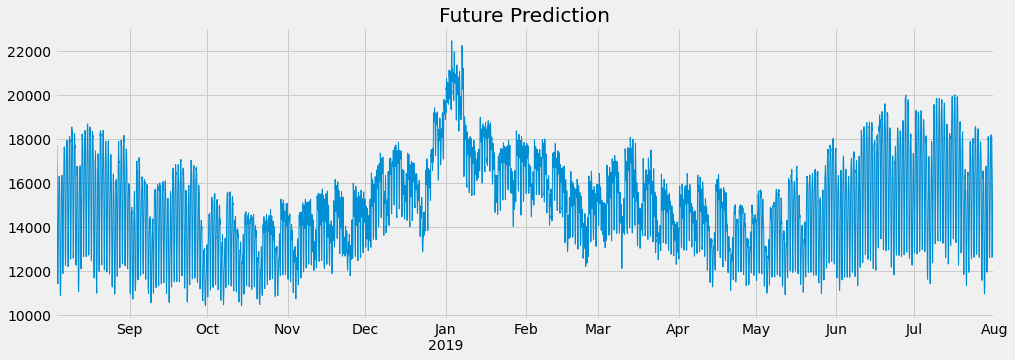

In [ ]:
future_with_features['pred'].plot(figsize=(15,5),ms=1,lw=1, title='Future Prediction')
plt.show()

In [ ]:
reg.save_model('model.json')